# **Dependencies**

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation
!pip install rouge-score

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-9c6s_870
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-9c6s_870
  Resolved https://github.com/huggingface/transformers to commit e4bd2c858daa5815aa271fde3b63c4a85923599d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 8.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for transformers: filename=transformers-4.56.0.dev0-py3-none-any.whl size=12431942 sha256=fb8453c48c019f697bd809db0dc6240b9e20eb109ae344566c1c566c34e9904c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ldzd2ikr/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-

# **Data Preprocessing , DataSet and DataLoaders**

In [9]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
import re
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

In [10]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [11]:
XML_REPORTS_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_reports/ecgen-radiology/"
IMAGES_PATH      = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/"

# Model & Training Params
TOKENIZER_NAME   = "gpt2"
BATCH_SIZE       = 8
MAX_SEQ_LENGTH   = 512
IMAGE_SIZE       = 224

# Data Split Params (R2Gen-style ratios commonly used in IU-Xray literature)
TRAIN_RATIO      = 0.80  # train
VALID_RATIO      = 0.10  # val
TEST_RATIO       = 0.10  # test
RANDOM_STATE     = 42

assert abs(TRAIN_RATIO + VALID_RATIO + TEST_RATIO - 1.0) < 1e-6, "Ratios must sum to 1."

In [12]:
import os, re, xml.etree.ElementTree as ET
from glob import glob
from tqdm import tqdm

def clean_text(text):
    if text is None:
        return ""
    text = text.lower().strip()
    text = text.replace('xxxx', '').replace('\n', ' ').replace('\r', ' ')
    text = ' '.join(text.split())
    return text

def extract_patient_id_from_xml(xml_path):
    """
    Derive a stable patient_id for IU X-ray:
    - Prefer deriving from the first parentImage id 'CXR####_IM-...'
      -> returns 'PID_####'
    - Fallback to numeric digits in the XML filename stem.
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        parent = root.find(".//parentImage")
        if parent is not None:
            pid_guess = parent.get('id') or ""
            m = re.search(r'CXR(\d+)', pid_guess)
            if m:
                return f"PID_{m.group(1)}"
    except Exception:
        pass
    stem = os.path.splitext(os.path.basename(xml_path))[0]
    m2 = re.search(r'(\d+)', stem)
    return f"PID_{m2.group(1) if m2 else stem}"

def extract_study_id_from_xml_path(xml_path):
    """
    Returns a per-study identifier from the XML filename (without extension).
    Example:
      xml_path = .../CXR1013_XXXX.xml -> study_id = CXR1013_XXXX
    """
    return os.path.splitext(os.path.basename(xml_path))[0]

def create_data_manifest(xml_dir, img_dir, tokenizer, max_seq_length=512):
    """
    Build per-study multi-view manifest with patient_id and study_id.
    Returns list of dicts:
      {
        'patient_id': str,
        'study_id': str,
        'image_paths': [list of .png paths for one study],
        'report_text': str
      }
    """
    manifest = []
    xml_files = glob(os.path.join(xml_dir, "*.xml"))
    print(f"Scanning {len(xml_files)} XML files to create manifest...")

    for xml_file in tqdm(xml_files, desc="Scanning XMLs"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            impression_node = root.find(".//AbstractText[@Label='IMPRESSION']")
            findings_node   = root.find(".//AbstractText[@Label='FINDINGS']")
            impression_text = clean_text(impression_node.text if impression_node is not None else "")
            findings_text   = clean_text(findings_node.text   if findings_node   is not None else "")
            if not findings_text and not impression_text:
                continue

            full_report = (
                f"<SECTION_FINDINGS> {findings_text} "
                f"<SECTION_IMPRESSION> {impression_text} "
                f"{tokenizer.eos_token}"
            ).strip()

            image_nodes = root.findall(".//parentImage")
            image_paths = []
            for node in image_nodes:
                image_filename = node.get('id') + ".png"
                image_path = os.path.join(img_dir, image_filename)
                if os.path.exists(image_path):
                    image_paths.append(image_path)

            if len(image_paths) == 0:
                continue

            patient_id = extract_patient_id_from_xml(xml_file)
            study_id = extract_study_id_from_xml_path(xml_file)

            manifest.append({
                'patient_id': patient_id,
                'study_id': study_id,
                'image_paths': image_paths,
                'report_text': full_report
            })
        except Exception as e:
            print(f"Warning: Could not process {os.path.basename(xml_file)}. Error: {e}")
    return manifest


In [13]:
import csv
import numpy as np

# CheXpert label order used in your CSV
CHEXPERT_LABELS = [
    "Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity","Lung Lesion","Edema",
    "Consolidation","Pneumonia","Atelectasis","Pneumothorax","Pleural Effusion",
    "Pleural Other","Fracture","Support Devices","No Finding"
]

RADGRAPH_LABELS_CSV = "/kaggle/input/chexpert-label/radgraph_chexpert_labels.csv"  # your output CSV

# Choose mapping policy: binary (uncertain→1) or soft (uncertain→0.5)
USE_SOFT_TARGETS = False  # set True if you want soft targets

def map_val_to_target(v, soft=USE_SOFT_TARGETS):
    if v is None or v == '' or str(v).lower() == 'nan':
        return 0.0
    x = float(v)
    if x == 1.0:   # present
        return 1.0
    if x == -1.0:  # uncertain
        return 0.5 if soft else 1.0
    # absent (0.0)
    return 0.0

# Load CSV into dict: study_id -> [14 targets]
radgraph_map = {}
with open(RADGRAPH_LABELS_CSV, "r") as f:
    reader = csv.DictReader(f)
    # sanity: ensure all columns exist (warn if not)
    missing_cols = [c for c in CHEXPERT_LABELS if c not in reader.fieldnames]
    if missing_cols:
        print("Warning: missing columns in CSV:", missing_cols)
    for row in reader:
        sid = row["study_id"]
        y = [map_val_to_target(row.get(lbl, "")) for lbl in CHEXPERT_LABELS]
        radgraph_map[sid] = y

print(f"Loaded RadGraph labels for {len(radgraph_map)} studies.")


Loaded RadGraph labels for 3927 studies.


In [16]:
from transformers import GPT2TokenizerFast

special_tokens_dict = {
    'additional_special_tokens': ['<SECTION_FINDINGS>', '<SECTION_IMPRESSION>']
}
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.pad_token = tokenizer.eos_token

In [19]:
from torch.utils.data import Dataset
import torch
from PIL import Image

class IUXRayDataset(Dataset):
    def __init__(self, manifest, tokenizer, image_transform, max_seq_length=512):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.transform = image_transform
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_paths = item['image_paths']  # list of views

        # Load views
        image_tensors = []
        for p in image_paths:
            image = Image.open(p).convert('RGB')
            image_tensor = self.transform(image)
            image_tensors.append(image_tensor)

        # Tokenize report
        tokenized = self.tokenizer(
            report_text,
            padding=True,
            truncation=True,
            max_length=self.max_seq_length
        )
        input_ids = tokenized['input_ids']
        labels = input_ids.copy()

        # Add 14-dim labels from manifest (float32)
        y14 = torch.tensor(item.get('chexpert_labels', [0.0]*14), dtype=torch.float32)

        return {
            "images": image_tensors,                 # list of (3,H,W)
            "input_ids": torch.tensor(input_ids),
            "labels": torch.tensor(labels),
            "image_paths": image_paths,
            "patient_id": item.get('patient_id', None),
            "chexpert_labels": y14                   # (14,)
        }


In [82]:
def custom_collate_fn(batch):
    """
    Custom collate_fn for multi-view radiology dataset.
    Handles variable number of views per patient and variable text length.
    """
    # --- Images ---
    image_lists = [item['images'] for item in batch]   # each: list[(3,H,W), ...]
    image_paths_lists = [item['image_paths'] for item in batch]

    # --- Text ---
    input_ids_list = [item['input_ids'] for item in batch]
    labels_list    = [item['labels'] for item in batch]

    # --- CheXpert labels ---
    y14_list = [item['chexpert_labels'] for item in batch]  # list of (14,)

    # -----------------------
    # Pad images to max_views
    # -----------------------
    max_views = max(len(images) for images in image_lists)
    batch_images, view_masks = [], []

    for images in image_lists:
        if len(images) == 0:
            raise ValueError("Found a sample with zero images/views. Check your manifest.")

        padded = images + [torch.zeros_like(images[0])] * (max_views - len(images))
        batch_images.append(torch.stack(padded))  # (V, 3, H, W)
        view_masks.append([1] * len(images) + [0] * (max_views - len(images)))

    batch_images = torch.stack(batch_images)                       # (B, V, 3, H, W)
    view_mask = torch.tensor(view_masks, dtype=torch.long)         # (B, V)

    # -----------------------
    # Pad text sequences
    # -----------------------
    pad_token_id = tokenizer.pad_token_id
    if pad_token_id is None:
        raise ValueError("tokenizer.pad_token_id is None. "
                         "Set tokenizer.pad_token = tokenizer.eos_token.")

    padded_inputs = tokenizer.pad(
        {"input_ids": input_ids_list},
        padding="longest",
        return_tensors="pt"
    )

    padded_labels = tokenizer.pad(
        {"input_ids": labels_list},
        padding="longest",
        return_tensors="pt"
    )["input_ids"]

    # mask out padding positions for loss
    padded_labels[padded_labels == pad_token_id] = -100

    # -----------------------
    # Stack CheXpert labels
    # -----------------------
    chexpert_labels = torch.stack(
        [torch.as_tensor(lbl, dtype=torch.float32) for lbl in y14_list],
        dim=0
    )  # (B, 14)

    # -----------------------
    # Return final batch dict
    # -----------------------
    return {
        "images": batch_images,                          # (B, V, 3, H, W)
        "view_mask": view_mask,                          # (B, V)
        "input_ids": padded_inputs["input_ids"],         # (B, T)
        "attention_mask": padded_inputs["attention_mask"],  # (B, T)
        "labels": padded_labels,                         # (B, T)
        "image_paths": image_paths_lists,                # list[list[str]]
        "chexpert_labels": chexpert_labels               # (B, 14)
    }

# **Loaded Data Visualization**

Scanning 3955 XML files to create manifest...


Scanning XMLs: 100%|██████████| 3955/3955 [00:36<00:00, 108.79it/s]


Total multi-view studies in manifest: 3826
Merged labels into manifest. Missing: 0

Data successfully split (patient-level, multi-view, no leakage):
Unique patients total: 3826
Train patients: 3061, Val patients: 383, Test patients: 382
Training studies:   3061
Validation studies: 383
Test studies:       382

PyTorch DataLoaders are ready!

--- Verifying a sample batch from the train_loader ---


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Batch keys: dict_keys(['images', 'view_mask', 'input_ids', 'attention_mask', 'labels', 'image_paths', 'chexpert_labels'])
Image tensor shape:      torch.Size([8, 3, 3, 224, 224])
View mask shape:         torch.Size([8, 3])
Input IDs tensor shape:  torch.Size([8, 85])
Attention mask shape:    torch.Size([8, 85])
Labels tensor shape:     torch.Size([8, 85])
First study image_paths: ['/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1401_IM-0256-1001.png', '/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1401_IM-0256-1002.png']


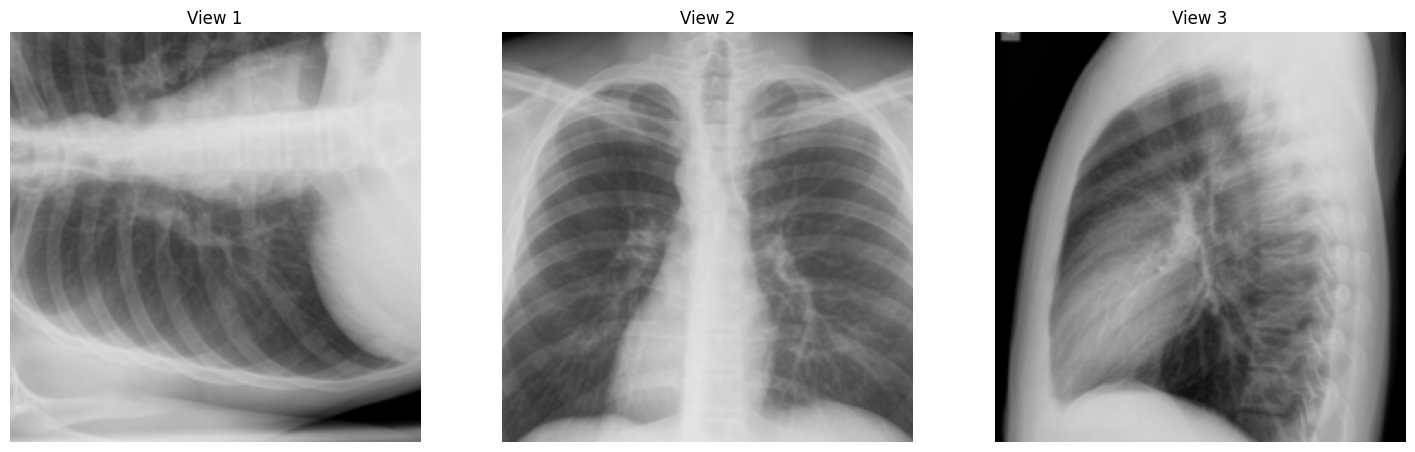


--- Sample Report (Decoded) ---
 cardiac and mediastinal contours are within normal limits. the lungs are clear. bony structures are intact.  negative chest x-. 
--------------------------------------------------


In [83]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms

# ImageNet normalization
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# Train-time transforms (data augmentation)
train_transform = transforms.Compose([
    transforms.Resize(256),                 # shorter side -> 256 (if input is non-square, torchvision keeps aspect ratio)
    transforms.RandomCrop(224),            # random 224x224 crop
    transforms.RandomHorizontalFlip(),     # horizontal flip with p=0.5
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Val/Test-time transforms (deterministic)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # direct resize to 224x224 (no crop, deterministic)
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


# --- Create manifest for multi-view ---
# 5) Build manifest and patient-level split
full_manifest = create_data_manifest(
    XML_REPORTS_PATH,
    IMAGES_PATH,
    tokenizer,
    max_seq_length=MAX_SEQ_LENGTH
)
print(f"Total multi-view studies in manifest: {len(full_manifest)}")

missing = 0
nf_idx = CHEXPERT_LABELS.index("No Finding")
for m in full_manifest:
    sid = m["study_id"]
    # Add 'PID_' prefix if missing
    if not sid.startswith("PID_"):
        sid = "PID_" + sid

    y = radgraph_map.get(sid, None)
    if y is None:
        y = [0.0] * len(CHEXPERT_LABELS)
        missing += 1

    y_arr = np.array(y, dtype=np.float32)
    other = np.delete(y_arr, nf_idx)
    y_arr[nf_idx] = 1.0 if other.sum() == 0 else 0.0
    m["chexpert_labels"] = y_arr.tolist()

print(f"Merged labels into manifest. Missing: {missing}")


# Unique patients and shuffled split
all_patients = sorted({m['patient_id'] for m in full_manifest})
random.Random(RANDOM_STATE).shuffle(all_patients)

n_patients = len(all_patients)
n_train = int(round(TRAIN_RATIO * n_patients))
n_val   = int(round(VALID_RATIO * n_patients))
n_test  = n_patients - n_train - n_val

train_patients = set(all_patients[:n_train])
val_patients   = set(all_patients[n_train:n_train+n_val])
test_patients  = set(all_patients[n_train+n_val:])

def filter_by_patients(manifest, keep_patients):
    return [m for m in manifest if m['patient_id'] in keep_patients]

train_manifest = filter_by_patients(full_manifest, train_patients)
val_manifest   = filter_by_patients(full_manifest, val_patients)
test_manifest  = filter_by_patients(full_manifest, test_patients)

print("\nData successfully split (patient-level, multi-view, no leakage):")
print(f"Unique patients total: {n_patients}")
print(f"Train patients: {len(train_patients)}, Val patients: {len(val_patients)}, Test patients: {len(test_patients)}")
print(f"Training studies:   {len(train_manifest)}")
print(f"Validation studies: {len(val_manifest)}")
print(f"Test studies:       {len(test_manifest)}")


# --- Create Datasets and DataLoaders for multi-view ---
# 6) Datasets and DataLoaders

train_dataset = IUXRayDataset(train_manifest, tokenizer, train_transform, max_seq_length=MAX_SEQ_LENGTH)
val_dataset   = IUXRayDataset(val_manifest,   tokenizer, val_transform, max_seq_length=MAX_SEQ_LENGTH)
test_dataset  = IUXRayDataset(test_manifest,  tokenizer, val_transform, max_seq_length=MAX_SEQ_LENGTH)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=custom_collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn
)

print("\nPyTorch DataLoaders are ready!")

print("\n--- Verifying a sample batch from the train_loader ---")

# --- Fetch one batch
# 7) Quick sanity check: one batch + visualize views

sample_batch = next(iter(train_loader))
print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['images'].shape}")       # (B,V,3,H,W)
print(f"View mask shape:         {sample_batch['view_mask'].shape}")    # (B,V)
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")    # (B,T)
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")
print(f"Labels tensor shape:     {sample_batch['labels'].shape}")
print(f"First study image_paths: {sample_batch['image_paths'][0]}")

# Visualize all (non-padded) views for a random study in the batch
idx_to_show = random.randint(0, sample_batch['images'].size(0) - 1)
images_to_show = sample_batch['images'][idx_to_show]  # (V,3,H,W)
view_mask = sample_batch['view_mask'][idx_to_show]    # (V,)
num_views = images_to_show.size(0)

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

valid_indices = [i for i in range(num_views) if view_mask[i].item() == 1]
plt.figure(figsize=(6 * len(valid_indices), 6))
for plot_idx, i in enumerate(valid_indices, start=1):
    img_tensor = images_to_show[i]
    img_display = (img_tensor * std) + mean
    img_display = transforms.ToPILImage()(img_display.clamp(0, 1))
    plt.subplot(1, len(valid_indices), plot_idx)
    plt.imshow(img_display)
    plt.title(f"View {i+1}")
    plt.axis('off')
plt.show()

# Decode report for that study
input_ids_display = sample_batch['input_ids'][idx_to_show]
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)
print("\n--- Sample Report (Decoded) ---")
print(report_display)
print("-" * 50)



In [84]:
import torch

def compute_pos_weight(manifest, label_key='chexpert_labels', num_labels=14, eps=1e-6):
    counts = np.zeros(num_labels, dtype=np.float64)
    total = 0
    for m in manifest:
        y = np.array(m[label_key], dtype=np.float32)
        counts += y
        total += 1
    pos = counts
    neg = total - pos
    pos_weight = (neg + eps) / (pos + eps)
    return torch.tensor(pos_weight, dtype=torch.float32)

pos_weight = compute_pos_weight(train_manifest, num_labels=len(CHEXPERT_LABELS))



# **MambaVision**

In [62]:
import torch
import torch.nn as nn
from transformers import AutoModel
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
import numpy as np
import cv2

class MambaVisionEncoder(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T-1K", device='cuda'):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
        self.device = device
        self.input_resolution = (3, 224, 224)

    def forward(self, image_tensor):
        """
        Input: image_tensor (B, 3, H, W)
        Output: pooled features (B, D), raw stage features (list of tensors)
        """
        image_tensor = image_tensor.to(self.device, non_blocking=True)
        pooled, features = self.model(image_tensor)
        return pooled, features

    def freeze(self):
        for p in self.parameters():
            p.requires_grad = False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad = True


config.json: 0.00B [00:00, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


model.safetensors:   0%|          | 0.00/127M [00:00<?, ?B/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


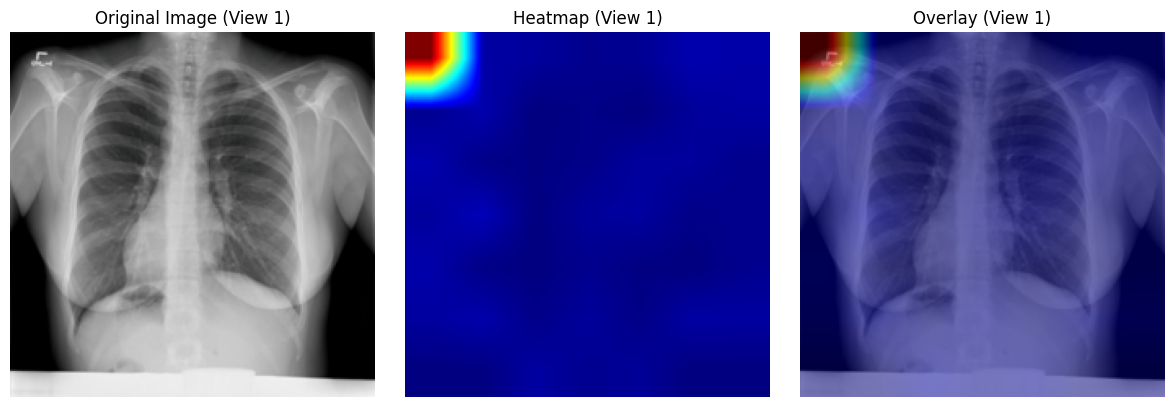

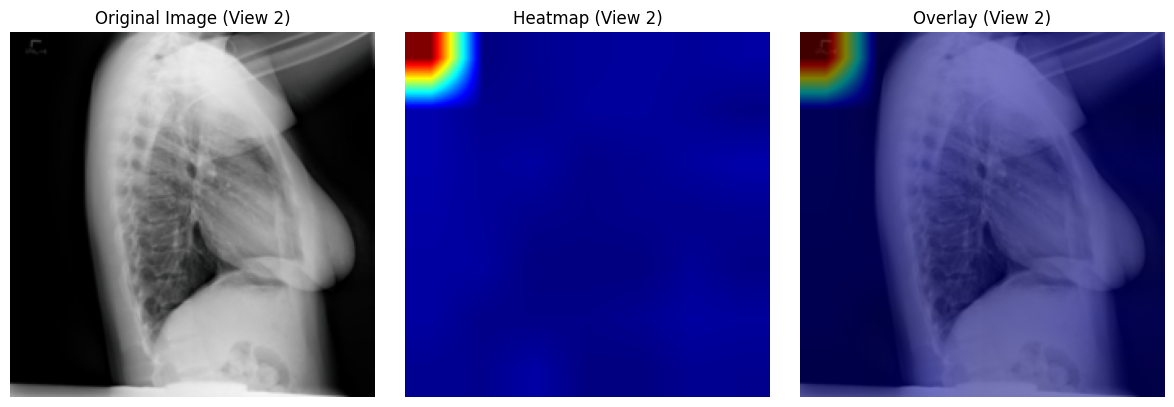

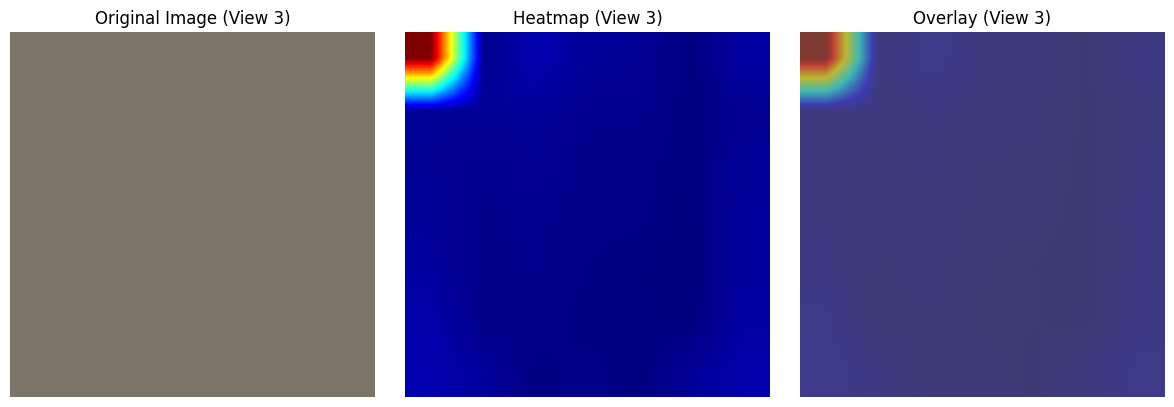

In [12]:

# === Instantiate encoder ===
encoder = MambaVisionEncoder().to('cuda')

# === Load a batch ===
sample_batch = next(iter(train_loader))
images = sample_batch['images'].to('cuda')  # shape: (B, max_views, 3, 224, 224)

# === Forward pass (extract features for all views, all samples) ===
B, V, C, H, W = images.shape
images_flat = images.view(B * V, C, H, W)  # flatten for encoder: (B*V, 3, 224, 224)

with torch.no_grad():
    pooled_feats, stage_feats = encoder(images_flat)  # pooled_feats: (B*V, 640), stage_feats: list of (B*V, 640, 7, 7)

# --- To visualize for the idx-th item in batch, loop through its views ---
idx = 0  # select which batch sample to visualize

for view_idx in range(V):
    # Retrieve the current view's original image and feature map
    image_tensor = images[idx, view_idx].cpu()
    feature_map = stage_feats[3][idx * V + view_idx]  # select correct index in flattened batch

    # === Generate heatmap ===
    activation_map = feature_map.mean(0).cpu().numpy()  # (7, 7)
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)
    activation_map = cv2.resize(activation_map, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # === Unnormalize image ===
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = (image_tensor * std) + mean
    img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()
    img = np.uint8(255 * img)

    # === Overlay heatmap ===
    overlay = np.uint8(0.5 * img + 0.5 * heatmap)

    # === Display ===
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image (View {view_idx+1})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title(f"Heatmap (View {view_idx+1})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay (View {view_idx+1})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# **Projection layer**

In [23]:
class VisualProjection(nn.Module):
    def __init__(self, vision_dim=640, gpt2_emb_dim=768, hidden_dim=1024, dropout=0.1):
        super().__init__()
        self.vision_dim = vision_dim
        self.gpt2_emb_dim = gpt2_emb_dim

        self.linear1 = nn.Linear(vision_dim, hidden_dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden_dim, gpt2_emb_dim)
        self.norm = nn.LayerNorm(gpt2_emb_dim)

        self.use_residual = (vision_dim == gpt2_emb_dim)
        self.residual_proj = nn.Identity() if self.use_residual else nn.Linear(vision_dim, gpt2_emb_dim)

    def forward(self, vision_feat):
        x = self.linear1(vision_feat)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.norm(x + self.residual_proj(vision_feat))
        return x


# **CustomGPT2**

In [24]:
class GPT2Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension must be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len

        self.c_attn = nn.Linear(self.embed_dim, self.embed_dim * 3, bias=True)
        self.scale = self.head_size ** -0.5
        self.register_buffer('mask', torch.tril(torch.ones(1, 1, self.seq_len, self.seq_len)))

        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)

    def forward(self, x):
        b, t, c = x.shape
        q, k, v = self.c_attn(x).chunk(3, dim=-1)
        q = q.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        k = k.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        v = v.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)

        att = (q @ k.transpose(-2, -1)) * self.scale
        att = att.masked_fill(self.mask[:, :, :t, :t] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        y = att @ v
        y = y.permute(0, 2, 1, 3).contiguous().view(b, t, c)
        y = self.c_proj(y)
        y = self.resid_dropout(y)
        return y

In [25]:
class GPT2CrossAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0
        self.head_size = self.embed_dim // self.n_heads

        self.q = nn.Linear(self.embed_dim, self.embed_dim)
        self.k = nn.Linear(self.embed_dim, self.embed_dim)
        self.v = nn.Linear(self.embed_dim, self.embed_dim)
        self.scale = self.head_size ** -0.5

        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, q_in, k_in, v_in):
        b, t, c = q_in.shape

        q = self.q(q_in)
        k = self.k(k_in)
        v = self.v(v_in)

        q = q.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        k = k.view(b, k.size(1), self.n_heads, self.head_size).permute(0, 2, 1, 3)
        v = v.view(b, v.size(1), self.n_heads, self.head_size).permute(0, 2, 1, 3)

        att = (q @ k.transpose(-2, -1)) * self.scale
        att = F.softmax(att, dim=-1)
        att_w = self.attn_dropout(att)

        y = att_w @ v
        y = y.permute(0, 2, 1, 3).contiguous().view(b, t, c)

        y = self.c_proj(y)
        y = self.resid_dropout(y)
        return y, att

In [26]:
class GPT2MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout

        self.c_fc = nn.Linear(self.embed_dim, self.embed_dim * self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim * self.mlp_ratio, self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [27]:
class GPT2Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)

    def forward(self, x, enc_out, return_attn=False):
        x = x + self.attn(self.ln_1(x))
        cross_out, cross_weights = self.cross_attn(self.ln_2(x), enc_out, enc_out)
        x = x + cross_out
        x = x + self.mlp(self.ln_3(x))
        if return_attn:
            return x, cross_weights
        return x

# **Main GPT2 Block**

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from types import SimpleNamespace

class CustomGPT2LM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.wte = nn.Embedding(config.vocab_size, config.embed_dim)
        self.wpe = nn.Embedding(config.seq_len, config.embed_dim)
        self.drop = nn.Dropout(config.emb_dropout)
        self.blocks = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f = nn.LayerNorm(config.embed_dim)
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size, bias=False)

    def resize_token_embeddings(self, new_num_tokens):
        old_embeddings = self.wte
        old_num_tokens, embedding_dim = old_embeddings.weight.shape
        if new_num_tokens == old_num_tokens:
            return self.wte

        new_embeddings = nn.Embedding(new_num_tokens, embedding_dim).to(old_embeddings.weight.device)
        nn.init.normal_(new_embeddings.weight, mean=0.0, std=0.02)
        num_to_copy = min(old_num_tokens, new_num_tokens)
        new_embeddings.weight.data[:num_to_copy, :] = old_embeddings.weight.data[:num_to_copy, :]
        self.wte = new_embeddings

        old_lm_head = self.lm_head
        new_lm_head = nn.Linear(embedding_dim, new_num_tokens, bias=False).to(old_lm_head.weight.device)
        nn.init.normal_(new_lm_head.weight, mean=0.0, std=0.02)
        num_to_copy = min(old_lm_head.weight.size(0), new_num_tokens)
        new_lm_head.weight.data[:num_to_copy, :] = old_lm_head.weight.data[:num_to_copy, :]
        self.lm_head = new_lm_head

        return self.wte

    def forward(self, input_ids, encoder_hidden_states=None, attention_mask=None,
                labels=None, return_attentions=False, capture_last_step_only=True):
        b, t = input_ids.size()
        device = input_ids.device
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0).expand(b, t)
        x = self.wte(input_ids) + self.wpe(pos)
        x = self.drop(x)

        cross_attn_per_layer = [] if return_attentions else None

        for block in self.blocks:
            if return_attentions:
                x, cross_w = block(x, encoder_hidden_states, return_attn=True)
                if capture_last_step_only:
                    cross_attn_per_layer.append(cross_w[:, :, -1:, :])  # (B,H,1,S)
                else:
                    cross_attn_per_layer.append(cross_w)               # (B,H,T,S)
            else:
                x = block(x, encoder_hidden_states, return_attn=False)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        if labels is not None:
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=-100
            )
            if return_attentions:
                return SimpleNamespace(loss=loss, logits=logits, cross_attentions=cross_attn_per_layer)
            return SimpleNamespace(loss=loss, logits=logits)
        else:
            if return_attentions:
                return SimpleNamespace(logits=logits, cross_attentions=cross_attn_per_layer)
            return SimpleNamespace(logits=logits)



# **EfficientMultiViewTransformerFusion**

In [29]:
class EfficientMultiViewTransformerFusion(nn.Module):
    def __init__(self, vision_dim, num_layers=1, num_heads=4, dropout=0.1, max_views=10):
        super().__init__()
        self.vision_dim = vision_dim
        self.max_views = max_views

        self.pos_embed = nn.Parameter(torch.zeros(1, max_views, vision_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=vision_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.pool_query = nn.Parameter(torch.randn(1, 1, vision_dim))
        self.pool_attention = nn.MultiheadAttention(
            embed_dim=vision_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

    def forward(self, feats, view_mask=None):
        """
        feats: (B, V, D); view_mask: (B, V) with 1 valid / 0 pad
        returns pooled: (B, D)
        """
        B, V, D = feats.shape
        assert V <= self.max_views, f"Number of views ({V}) cannot exceed max_views ({self.max_views})"

        pos_emb = self.pos_embed[:, :V, :]
        feats = feats + pos_emb

        key_padding_mask = None
        if view_mask is not None:
            key_padding_mask = (view_mask == 0)  # bool, True means pad

        encoded = self.transformer(feats, src_key_padding_mask=key_padding_mask)  # (B, V, D)

        query = self.pool_query.expand(B, -1, -1)
        attn_output, attn_weights = self.pool_attention(
            query=query,
            key=encoded,
            value=encoded,
            key_padding_mask=key_padding_mask
        )
        pooled = attn_output.squeeze(1)
        return pooled


# **Main Block**

In [101]:
import torch
import torch.nn as nn

class VisionLanguageWrapper(nn.Module):
    def __init__(self, vision_encoder, proj_layer, custom_gpt2, fusion_module, device='cuda',num_chexpert_labels=14,pos_weight=None):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.proj_layer = proj_layer
        self.gpt2 = custom_gpt2
        self.fusion_module = fusion_module
        self.device = device
        self.pos_weight = pos_weight
        self.chexpert_head = nn.Sequential(
            nn.Linear(proj_layer.gpt2_emb_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_chexpert_labels)
        )
    def forward(self, images, input_ids, attention_mask=None, labels=None,chexpert_labels=None,
                view_mask=None, return_attentions=False, capture_last_step_only=True):
        # images: (B, V, C, H, W)
        B, V, C, H, W = images.shape
        images_flat = images.view(B * V, C, H, W)

        pooled_feats_flat, _ = self.vision_encoder(images_flat)                # (B*V, D)
        vision_dim = pooled_feats_flat.shape[-1]
        pooled_feats = pooled_feats_flat.view(B, V, vision_dim)               # (B, V, D)
        fused_feats = self.fusion_module(pooled_feats, view_mask=view_mask)   # (B, D)
        visual_emb = self.proj_layer(fused_feats).unsqueeze(1)                # (B, 1, E)
        chexpert_logits = self.chexpert_head(visual_emb).squeeze(1)  # (B,14)
        lm_outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=visual_emb,  # ✔️ fixed
            labels=labels,
            return_attentions=return_attentions,
            capture_last_step_only=capture_last_step_only
        )
        if chexpert_labels is not None:
            # Use BCEWithLogitsLoss with pos_weight for class imbalance
            if not torch.is_tensor(chexpert_labels):
                chexpert_labels = torch.tensor(chexpert_labels, dtype=torch.float32, device=self.device)
            else:
                chexpert_labels = chexpert_labels.to(self.device).float()
            alpha = 0.8 
            chexpert_loss = F.binary_cross_entropy_with_logits(
                chexpert_logits, chexpert_labels,
                pos_weight=self.pos_weight.to(self.device) if self.pos_weight is not None else None
            )
            # Combine losses: weighted sum
            total_loss = alpha * lm_outputs.loss + (1-alpha) * chexpert_loss
            return SimpleNamespace(loss=total_loss, lm_loss=lm_outputs.loss, chexpert_loss=chexpert_loss,
                                  logits=lm_outputs.logits, chexpert_logits=chexpert_logits)
        else:
            return SimpleNamespace(loss=lm_outputs.loss, lm_loss=lm_outputs.loss ,logits=lm_outputs.logits, chexpert_logits=chexpert_logits)

    # Explicit freezing helpers
    def freeze_vision_encoder(self):
        self.vision_encoder.freeze()

    def unfreeze_vision_encoder(self):
        self.vision_encoder.unfreeze()

    def freeze_text_decoder(self):
        for p in self.gpt2.parameters():
            p.requires_grad = False

    def unfreeze_text_decoder(self):
        for p in self.gpt2.parameters():
            p.requires_grad = True

    def freeze_projection(self):
        for p in self.proj_layer.parameters():
            p.requires_grad = False

    def unfreeze_projection(self):
        for p in self.proj_layer.parameters():
            p.requires_grad = True

    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')

    # Requested: do train/eval switching here, not in Trainer
    def set_train_mode(self):
        self.train()
        # If you want to keep specific parts frozen, call freeze_* before or after this method as needed.

    def set_eval_mode(self):
        self.eval()
    # Add inside VisionLanguageWrapper
    def visual_extractor_parameters(self):
        # Vision backbone + projection belong to "visual extractor"
        for p in self.vision_encoder.parameters():
            if p.requires_grad:
                yield p
        for p in self.proj_layer.parameters():
            if p.requires_grad:
                yield p
    
    def decoder_parameters(self):
        ve_ids = set(map(id, self.visual_extractor_parameters()))
        for p in self.parameters():
            if p.requires_grad and id(p) not in ve_ids:
                yield p


    @classmethod
    def from_pretrained(cls, vision_encoder, proj_layer, gpt2_config, custom_gpt2_class,
                        fusion_module, tokenizer, device='cuda'):
        custom_gpt2 = custom_gpt2_class(gpt2_config)
        custom_gpt2.resize_token_embeddings(len(tokenizer))

        hf_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
        hf_sd = hf_gpt2.state_dict()
        custom_sd = custom_gpt2.state_dict()

        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        ignore_matches = ["cross_attn.", "ln_3"]

        for k in hf_sd.keys():
            if any(match in k for match in ignore_matches):
                continue
            if k not in custom_sd:
                continue
            if any(k.endswith(w) for w in transposed):
                if hf_sd[k].shape[::-1] == custom_sd[k].shape:
                    with torch.no_grad():
                        custom_sd[k].copy_(hf_sd[k].t())
            elif hf_sd[k].shape == custom_sd[k].shape:
                with torch.no_grad():
                    custom_sd[k].copy_(hf_sd[k])

        custom_gpt2.load_state_dict(custom_sd, strict=False)
        return cls(vision_encoder, proj_layer, custom_gpt2, fusion_module, device=device).to(device)



In [102]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 640,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)

# Training-related configuration
train_config = SimpleNamespace(
    epochs = 10,
    freeze_epochs_gpt = 2,        # unfreeze GPT-2 at epoch 3 (0-based index)
    freeze_epochs_all = 3,        # unfreeze vision/proj at epoch 4
    lr = 5e-4,
    device = 'cuda',
    model_path = Path('vl_captioner'),
    batch_size = 8,
    optim = 'AdamW',          # or 'Adam'
    lr_ve = 5e-5,             # vision+proj LR (smaller)
    lr_ed = 5e-4,             # decoder+fusion LR
    weight_decay = 1e-4,
    amsgrad = False,
    lr_scheduler = 'StepLR',
    step_size = 1,            # decay every epoch
    gamma = 0.9,
    class_weights = pos_weight.cpu().numpy()
    
    # If you prefer OneCycleLR instead:
    # lr_scheduler = 'OneCycleLR',
    # total_steps = train_config.epochs * len(train_loader),
    # del train_config.step_size, train_config.gamma,
)
print("Computed pos_weight:", train_config.class_weights)# multiply LR by 0.9 each step


Computed pos_weight: [5.4851694e+00 1.2308696e+01 1.8496815e+01 2.3446152e+02 4.9180328e+01
 1.1237037e+02 5.0016666e+01 9.8162546e+00 1.5204999e+02 2.1021582e+01
 4.7305101e-01 3.5440475e+01 3.0599968e+03 4.4081273e+00]


In [103]:
vision_encoder = MambaVisionEncoder(model_name="nvidia/MambaVision-T-1K", device=train_config.device)

# projection
proj_layer = VisualProjection(
    vision_dim=model_config.vision_dim,
    gpt2_emb_dim=model_config.gpt2_emb_dim
).to(train_config.device)

# fusion
fusion_module = EfficientMultiViewTransformerFusion(
    vision_dim=model_config.vision_dim,
    num_layers=3,
    num_heads=8,
    dropout=0.1
).to(train_config.device)

# wrapper (note: pass tokenizer here)
vl_model = VisionLanguageWrapper.from_pretrained(
    vision_encoder=vision_encoder,
    proj_layer=proj_layer,
    gpt2_config=model_config,
    custom_gpt2_class=CustomGPT2LM,
    fusion_module=fusion_module,
    tokenizer=tokenizer,
    device=train_config.device
)

# Example freeze schedule before training
# e.g., start with decoder only
vl_model.freeze_vision_encoder()
vl_model.freeze_projection()
vl_model.unfreeze_text_decoder()
vl_model.print_trainable_parameters()

Trainable params: 205,958,286 / 239,689,942


In [85]:
import torch

def build_optimizer(args, model):
    # Expect model = VisionLanguageWrapper
    ve_params = list(model.visual_extractor_parameters())
    ed_params = list(model.decoder_parameters())

    OptimClass = getattr(torch.optim, args.optim)  # e.g., 'AdamW' or 'Adam'
    optimizer = OptimClass(
        [
            {'params': ve_params, 'lr': args.lr_ve},
            {'params': ed_params, 'lr': args.lr_ed},
        ],
        weight_decay=args.weight_decay,
        amsgrad=getattr(args, 'amsgrad', False) if hasattr(args, 'amsgrad') else False
    )
    return optimizer


def build_lr_scheduler(args, optimizer):
    # Example: StepLR; you can set args.lr_scheduler='OneCycleLR' etc.
    # For OneCycleLR, use total_steps or epochs+steps_per_epoch carefully (see below).
    SchedClass = getattr(torch.optim.lr_scheduler, args.lr_scheduler)

    # Default: StepLR requires step_size and gamma
    if args.lr_scheduler == 'StepLR':
        lr_scheduler = SchedClass(optimizer, step_size=args.step_size, gamma=args.gamma)
        return lr_scheduler

    # Optional: OneCycleLR variant using total_steps for robustness
    if args.lr_scheduler == 'OneCycleLR':
        # Need args.total_steps OR (epochs and steps_per_epoch)
        if hasattr(args, 'total_steps') and args.total_steps is not None:
            lr_scheduler = SchedClass(optimizer, max_lr=[args.lr_ve, args.lr_ed], total_steps=args.total_steps)
        else:
            lr_scheduler = SchedClass(
                optimizer,
                max_lr=[args.lr_ve, args.lr_ed],
                epochs=args.epochs,
                steps_per_epoch=args.steps_per_epoch
            )
        return lr_scheduler

    # Fallback: construct with common kwargs if present
    try:
        lr_scheduler = SchedClass(optimizer, args.step_size, args.gamma)
    except TypeError:
        lr_scheduler = SchedClass(optimizer)
    return lr_scheduler


In [86]:
from torch.utils.data import Sampler
import random

class ClassAwareSampler(Sampler):
    def __init__(self, manifest, label_key='chexpert_labels', batch_size=8, rare_frac=0.25, rare_thresh=0.05):
        self.manifest = manifest
        self.batch_size = batch_size
        self.rare_frac = rare_frac

        self.num_labels = len(manifest[0][label_key])
        # Calculate per-class positive indices
        self.class_positive_indices = [[] for _ in range(self.num_labels)]
        for idx, m in enumerate(manifest):
            for c, v in enumerate(m[label_key]):
                if v == 1.0:
                    self.class_positive_indices[c].append(idx)

        # Identify rare classes (below rare_thresh portion)
        counts = [len(lst) for lst in self.class_positive_indices]
        N = len(manifest)
        self.rare_classes = [i for i, count in enumerate(counts) if count/N < rare_thresh]

        self.remaining_indices = list(range(N))

    def __iter__(self):
        N = len(self.manifest)
        yielded = set()
        indices = []
    
        while len(indices) < N:
            batch = []
            # rare picks
            rare_idxs = []
            for cls in self.rare_classes:
                pool = [i for i in self.class_positive_indices[cls] if i not in yielded]
                if pool:
                    rare_idxs.append(random.choice(pool))
            while len(rare_idxs) < min(self.batch_size * self.rare_frac, N - len(indices)):
                cls = random.choice(self.rare_classes) if self.rare_classes else 0
                pool = [i for i in self.class_positive_indices[cls] if i not in yielded]
                if not pool:
                    break
                rare_idxs.append(random.choice(pool))
            batch += rare_idxs
    
            # fill remaining
            remaining = [i for i in range(N) if i not in yielded and i not in batch]
            need = min(self.batch_size - len(batch), N - len(indices))
            if remaining:
                batch += random.sample(remaining, min(len(remaining), need))
    
            for idx in batch:
                if idx not in yielded:
                    indices.append(idx)
                    yielded.add(idx)
    
        return iter(indices)
    
    def __len__(self):
        return len(self.manifest)


In [88]:
sampler = ClassAwareSampler(
    train_manifest,
    batch_size=8,
    rare_frac=0.25,
    rare_thresh=0.05
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    sampler=sampler,
    collate_fn=custom_collate_fn,   # ✅ add here
    num_workers=4,                  # optional, for speed
    pin_memory=True                 # optional, for GPU training
)

# **Trainer Class**

In [95]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
class Trainer:
    def __init__(self, vl_model, tokenizer, train_config, dls):
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device

        self.train_dl, self.val_dl = dls
        self.scaler = torch.cuda.amp.GradScaler()
        self.opt_args = SimpleNamespace(
            optim=getattr(train_config, 'optim', 'AdamW'),
            lr_ve=getattr(train_config, 'lr_ve', train_config.lr * 0.1),
            lr_ed=getattr(train_config, 'lr_ed', train_config.lr),
            weight_decay=getattr(train_config, 'weight_decay', 1e-4),
            amsgrad=getattr(train_config, 'amsgrad', False),
            lr_scheduler=getattr(train_config, 'lr_scheduler', 'StepLR'),
            step_size=getattr(train_config, 'step_size', 1),   # every epoch by default
            gamma=getattr(train_config, 'gamma', 0.85),        # decay factor
            # For OneCycleLR (optional):
            epochs=train_config.epochs,
            steps_per_epoch=len(self.train_dl),
            total_steps=getattr(train_config, 'total_steps', None),
        )

        self.optim = build_optimizer(self.opt_args, self.vl_model)
        self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim)

        self.metrics = pd.DataFrame()
        self.metrics[['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity']] = None

    @torch.no_grad()
    def visualize_cross_attention(self, num_batches=1, capture_last_step_only=True):
        self.vl_model.set_eval_mode()
        batches = 0
        for batch in self.val_dl:
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device, non_blocking=True)
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            labels = batch['labels'].to(self.device, non_blocking=True)

            out = self.vl_model(
                images=images,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                view_mask=view_mask,
                return_attentions=True,
                capture_last_step_only=capture_last_step_only
            )
            cross_list = out.cross_attentions

            bidx = 0
            layer_maps = []
            for att in cross_list:
                if capture_last_step_only:
                    att_b = att[bidx]           # (H,1,S)
                    att_avg = att_b.mean(dim=0) # (1,S)
                else:
                    att_b = att[bidx]           # (H,T,S)
                    att_avg = att_b.mean(dim=0) # (T,S)
                layer_maps.append(att_avg.cpu().squeeze(0).numpy() if capture_last_step_only else att_avg.cpu().numpy())

            last_map = layer_maps[-1]
            plt.figure(figsize=(6, 4))
            if capture_last_step_only:
                plt.bar(range(last_map.shape[-1]), last_map)
                plt.title("Last layer cross-attention (avg heads) to visual tokens")
                plt.xlabel("Visual token index")
                plt.ylabel("Attention weight")
            else:
                plt.imshow(last_map, aspect='auto', cmap='viridis')
                plt.colorbar()
                plt.title("Last layer cross-attention (avg heads): text x visual")
                plt.xlabel("Visual token index")
                plt.ylabel("Text token index")
            plt.tight_layout()
            plt.show()

            batches += 1
            if batches >= num_batches:
                break

    def save_model(self):
        self.train_config.model_path.mkdir(exist_ok=True)
        torch.save(self.vl_model.state_dict(), self.train_config.model_path / 'vl_model.pt')

    def load_best_model(self):
        sd = torch.load(self.train_config.model_path / 'vl_model.pt', map_location=self.device)
        self.vl_model.load_state_dict(sd)

    def load_model_from_path(self, checkpoint_path):
        sd = torch.load(checkpoint_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)

    def train_one_epoch(self, epoch):
        self.vl_model.set_train_mode()
        running_loss = 0.0
        lm_loss_accum = 0.0
        total_batches = len(self.train_dl)

        for batch in self.train_dl:
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device, non_blocking=True)
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            chexpert_labels = batch['chexpert_labels'].to(self.device, non_blocking=True)  # shape (B, 14)

            self.optim.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                outputs = self.vl_model(
                    images, input_ids, attention_mask=attention_mask,
                    labels=labels, view_mask=view_mask,
                    chexpert_labels=chexpert_labels
                )
                loss = outputs.loss  # combined loss
                lm_loss_val = outputs.lm_loss.item() if hasattr(outputs, "lm_loss") else loss.item()

           
            train_loss = running_loss / total_batches
            train_pxp  = np.exp(lm_loss_accum / total_batches)  # accumulate lm_loss during loop

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optim)
            self.scaler.update()

            running_loss += loss.item()

            del images, input_ids, labels, attention_mask, loss

        train_loss = running_loss / total_batches
        train_pxp  = np.exp(lm_loss_accum / total_batches)  # accumulate lm_loss during loop
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Perplexity: {train_pxp:.4f}")
        return train_pxp

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.set_eval_mode()
        running_loss = 0.0
        lm_loss_accum = 0.0
        total_batches = len(self.val_dl)

        for batch in self.val_dl:
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device, non_blocking=True)
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            chexpert_labels = batch['chexpert_labels'].to(self.device, non_blocking=True)  # shape (B, 14)
            with torch.cuda.amp.autocast():
                outputs = self.vl_model(
                    images, input_ids, attention_mask=attention_mask,
                    labels=labels, view_mask=view_mask,
                    chexpert_labels=chexpert_labels
                )
                loss = outputs.loss  # combined loss
                lm_loss_val = outputs.lm_loss.item() if hasattr(outputs, "lm_loss") else loss.item()

            running_loss += loss.item()

            del images, input_ids, labels, attention_mask, loss

        val_loss = running_loss / total_batches
        val_pxp  = np.exp(lm_loss_accum / total_batches)  # accumulate lm_loss during loop
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1} | Valid Loss: {val_loss:.4f} | Perplexity: {val_pxp:.4f}")
        return val_pxp

    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()

    def fit(self):
        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))

        for epoch in prog:
            if epoch == getattr(self.train_config, 'freeze_epochs_gpt', None):
                self.vl_model.unfreeze_text_decoder()
                print('Unfreezing GPT-2 decoder...')
                self.optim = build_optimizer(self.opt_args, self.vl_model)
                self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim)
            if epoch == getattr(self.train_config, 'freeze_epochs_all', None):
                self.vl_model.unfreeze_vision_encoder()
                self.vl_model.unfreeze_projection()
                print('Unfreezing vision encoder and projection...')
                self.optim = build_optimizer(self.opt_args, self.vl_model)
                self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim)

            # Rebuild optimizer if trainability changed? Optional:
            # self.optim = build_optimizer(self.opt_args, self.vl_model)

            train_pxp = self.train_one_epoch(epoch)
            self.clean()
            val_pxp = self.valid_one_epoch(epoch)
            self.clean()
            print(self.metrics.tail(1))

            # StepLR: step once per epoch
            if isinstance(self.lr_scheduler, torch.optim.lr_scheduler.StepLR):
                self.lr_scheduler.step()

            if val_pxp < best_pxp:
                best_pxp = val_pxp
                best_epoch = epoch
                print('Saving best model...')
                self.save_model()

        return {'best_perplexity': best_pxp, 'best_epoch': best_epoch}

    def plot_loss_and_perplexity(self):
        if self.metrics is None or self.metrics.empty:
            print("No metrics to plot yet.")
            return
        epochs = range(1, len(self.metrics) + 1)
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.metrics['train_loss'], label='Train Loss')
        plt.plot(epochs, self.metrics['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epochs')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.metrics['train_perplexity'], label='Train Perplexity')
        plt.plot(epochs, self.metrics['val_perplexity'], label='Validation Perplexity')
        plt.xlabel('Epoch')
        plt.ylabel('Perplexity')
        plt.title('Perplexity vs Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()
    @staticmethod
    @torch.no_grad()
    def clean_and_format_report(generated_report: str) -> str:
        rep = generated_report.replace('<SECTION_FINDINGS>', '\nFindings:').replace('<SECTION_IMPRESSION>', '\nImpression:')
        patterns = {k: re.compile(rf'{k}:(.*?)((?=\n[a-zA-Z]+:)|$)', re.DOTALL) for k in ['Findings', 'Impression']}
        sections = {k: (patterns[k].search(rep).group(1).strip() if patterns[k].search(rep) else "") for k in patterns}
    
        for k in sections:
            lines = []
            for line in re.split(r'(?<=\.)\s+', sections[k]):
                if line and line not in lines:
                    lines.append(line)
            sections[k] = " ".join(lines).strip()
    
        report = f"Findings: {sections['Findings']}\nImpression: {sections['Impression']}"
        return report
    
    @staticmethod
    @torch.no_grad()
    def robust_generate_radiology_report(vl_model, tokenizer, image_input,
                                         max_tokens=120, temperature=1.0,
                                         top_k=None, top_p=None, beam_width=1,
                                         num_return_sequences=1, temperature_range=None,
                                         deterministic=False, show_image=False, device='cuda'):
        vl_model.set_eval_mode()
    
        img_list = []
        if isinstance(image_input, list):
            for img in image_input:
                if isinstance(img, (str, bytes, os.PathLike)):
                    im = Image.open(img).convert('RGB')
                elif isinstance(img, Image.Image):
                    im = img.convert('RGB')
                else:
                    raise ValueError("Each item must be a file path or PIL.Image.")
                img_list.append(im)
        else:
            if isinstance(image_input, (str, bytes, os.PathLike)):
                img_list = [Image.open(image_input).convert('RGB')]
            elif isinstance(image_input, Image.Image):
                img_list = [image_input.convert('RGB')]
            else:
                raise ValueError("image_input should be a file path, PIL.Image, or a list thereof.")
    
        if show_image:
            plt.figure(figsize=(6 * len(img_list), 6))
            for i, img in enumerate(img_list):
                plt.subplot(1, len(img_list), i + 1)
                plt.imshow(img)
                plt.title(f"Image View {i+1}")
                plt.axis('off')
            plt.show()
    
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        imgs_pp = [transform(img) for img in img_list]
        imgs_pp = torch.stack(imgs_pp)  # (V, C, H, W)
        imgs_pp = imgs_pp.unsqueeze(0).to(device)  # (1, V, C, H, W)
        num_views = imgs_pp.shape[1]
        view_mask = torch.ones(1, num_views, device=device)
    
        section_token = "<SECTION_FINDINGS>"
        section_token_id = tokenizer.convert_tokens_to_ids(section_token)
    
        if temperature_range is not None and not deterministic:
            temperature = np.random.uniform(*temperature_range)
    
        def step_once(seq_tokens):
            feats_flat, _ = vl_model.vision_encoder(imgs_pp.view(-1, *imgs_pp.shape[2:]))
            vision_dim = feats_flat.shape[-1]
            feats = feats_flat.view(1, num_views, vision_dim)
            fused_feats = vl_model.fusion_module(feats, view_mask)
            visual_emb = vl_model.proj_layer(fused_feats).unsqueeze(1)
    
            out = vl_model.gpt2(seq_tokens, encoder_hidden_states=visual_emb).logits
            logits = out[:, -1, :] / temperature
    
            filtered_logits = logits.clone()
            if top_k is not None:
                tk = min(top_k, logits.size(-1))
                thresh = torch.topk(filtered_logits, tk)[0][..., -1, None]
                filtered_logits[filtered_logits < thresh] = -float('Inf')
    
            if top_p is not None:
                sorted_logits, sorted_indices = torch.sort(filtered_logits, descending=True)
                cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                remove = cumulative_probs > top_p
                remove[..., 1:] = remove[..., :-1].clone()
                remove[..., 0] = 0
                filtered_logits.scatter_(1, sorted_indices[remove], -float('Inf'))
    
            probs = torch.softmax(filtered_logits, dim=-1)
            if deterministic:
                next_token = torch.argmax(probs, dim=-1, keepdim=True)
            else:
                next_token = torch.multinomial(probs, num_samples=1)
            return next_token
    
        if beam_width > 1:
            sequences = [(torch.tensor([[section_token_id]], dtype=torch.long, device=device), 0.0)]
            for _ in range(max_tokens):
                all_candidates = []
                for seq, score in sequences:
                    feats_flat, _ = vl_model.vision_encoder(imgs_pp.view(-1, *imgs_pp.shape[2:]))
                    vision_dim = feats_flat.shape[-1]
                    feats = feats_flat.view(1, num_views, vision_dim)
                    fused_feats = vl_model.fusion_module(feats, view_mask)
                    visual_emb = vl_model.proj_layer(fused_feats).unsqueeze(1)
    
                    logits = vl_model.gpt2(seq, encoder_hidden_states=visual_emb).logits[:, -1, :] / temperature
                    log_probs = torch.log_softmax(logits, dim=-1).squeeze(0)
                    topk_log_probs, topk_indices = torch.topk(log_probs, beam_width)
    
                    for k in range(beam_width):
                        next_token = topk_indices[k].unsqueeze(0).unsqueeze(0)
                        candidate_seq = torch.cat([seq, next_token], dim=1)
                        candidate_score = score + topk_log_probs[k].item()
                        all_candidates.append((candidate_seq, candidate_score))
    
                sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
                if all(seq[0, -1].item() == tokenizer.eos_token_id for seq in sequences):
                    break
            sequence = sequences
        else:
            if num_return_sequences == 1:
                sequence = torch.tensor([[section_token_id]], dtype=torch.long, device=device)
                for _ in range(max_tokens):
                    next_token = step_once(sequence)
                    sequence = torch.cat([sequence, next_token], dim=1)
                    if next_token.item() == tokenizer.eos_token_id:
                        break
            else:
                candidates = []
                for _ in range(num_return_sequences):
                    seq = torch.tensor([[section_token_id]], dtype=torch.long, device=device)
                    for _ in range(max_tokens):
                        next_token = step_once(seq)
                        seq = torch.cat([seq, next_token], dim=1)
                        if next_token.item() == tokenizer.eos_token_id:
                            break
                    candidates.append(seq)
    
                scored = []
                for seq in candidates:
                    feats_flat, _ = vl_model.vision_encoder(imgs_pp.view(-1, *imgs_pp.shape[2:]))
                    vision_dim = feats_flat.shape[-1]
                    feats = feats_flat.view(1, num_views, vision_dim)
                    fused_feats = vl_model.fusion_module(feats, view_mask)
                    visual_emb = vl_model.proj_layer(fused_feats).unsqueeze(1)
                    logits_seq = vl_model.gpt2(seq[:, :-1], encoder_hidden_states=visual_emb).logits
                    log_probs = torch.log_softmax(logits_seq, dim=-1)
                    token_log_probs = log_probs.gather(-1, seq[:, 1:].unsqueeze(-1)).squeeze(-1)
                    avg_log_prob = token_log_probs.mean().item()
                    scored.append((seq, avg_log_prob))
                scored.sort(key=lambda x: x[1], reverse=True)
                sequence = scored
    
        report = tokenizer.decode(sequence.tolist(), skip_special_tokens=False)
        final_report = clean_and_format_report(report)
        return final_report
    


In [104]:
trainer = Trainer(
    vl_model,                      # your VisionLanguageWrapper instance
    tokenizer,                     # your GPT-2 tokenizer
    train_config,                  # your training config (SimpleNamespace)
    (train_loader, val_loader)  # tuple of your dataloaders
)

/tmp/ipykernel_36/719530994.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [ ]:
trainer.fit()

  0%|          | 0/10 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_36/719530994.py:124: FutureWarning: `torch.

Epoch 1 | Train Loss: 2.0904 | Perplexity: 1.0000


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_36/719530994.py:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Valid Loss: 1.5400 | Perplexity: 1.0000
  train_loss train_perplexity  val_loss val_perplexity
0   2.090439              1.0  1.540012            1.0
Saving best model...


 10%|█         | 1/10 [02:11<19:42, 131.40s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_36/719530994.py:124: FutureWarning

# **Loading Trained Model**

In [ ]:
trainer.load_best_model()

In [ ]:
trainer.load_model_from_path("/kaggle/input/test-model-mambavision/vl_model-3.pt")

In [ ]:
trainer.visualize_cross_attention(num_batches=1, capture_last_step_only=False)

# **Report Genearation**

In [44]:
report_beam = trainer.robust_generate_radiology_report(
    image_input=["/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1013_IM-0013-2001.png"],
    max_tokens=200,
    deterministic=True,     # Greedy inside each beam step (no sampling)
    beam_width=5,           # Beam search enabled
    top_k=None,             # Not used in deterministic + beam mode
    top_p=None,             # Not used in deterministic + beam mode
    num_return_sequences=1, # Not used in beam mode
    show_image=False,
    tokenizer=tokenizer
)
print("Generated report (beam):\n", report_beam)


AttributeError: 'Trainer' object has no attribute 'set_eval_mode'

In [ ]:
from torch.utils.data import ConcatDataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
combined_dataset = ConcatDataset([train_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=16, collate_fn=custom_collate_fn)


In [ ]:
from torch.utils.data import ConcatDataset, DataLoader
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
def evaluate_dataloader_metrics_v2(dataloader, trainer, tokenizer, device, max_samples=None):
    results = []
    sample_count = 0
    smooth = SmoothingFunction()
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    for batch in tqdm(dataloader, desc="Evaluating dataset"):
        input_ids = batch['input_ids']
        image_paths_list = batch['image_paths']  # <- list of lists: one per sample

        for i in range(len(image_paths_list)):
            if max_samples and sample_count >= max_samples:
                break

            gt_input_ids = input_ids[i]
            if tokenizer.pad_token_id is not None:
                gt_input_ids = gt_input_ids[gt_input_ids != tokenizer.pad_token_id]
            reference_text = tokenizer.decode(gt_input_ids, skip_special_tokens=True)
            if not isinstance(reference_text, str) or len(reference_text.strip()) == 0:
                continue

            # --- Load all image views for this report ---
            pil_imgs = []
            for image_path in image_paths_list[i]:
                pil_img = Image.open(image_path).convert('RGB')
                pil_imgs.append(pil_img)
            # --- Generate report from all images for this study ---
            gen_report = trainer.robust_generate_radiology_report(
                pil_imgs,    # passing list of PIL images for multi-view support
                deterministic=True
            )
            
            
            # --- TOKENIZATION FOR METRICS ---
            ref_tokens = word_tokenize(reference_text)
            hyp_tokens = word_tokenize(gen_report)
            # BLEU scores for n = 1, 2, 3, 4
            bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
            bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
            bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
            bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method1)

            # METEOR (pass as strings, NOT as lists)
            meteor = single_meteor_score(ref_tokens, hyp_tokens)


            # ROUGE-L
            rouge_l_score = rouge.score(reference_text, gen_report)['rougeL'].fmeasure

            results.append({
                'BLEU-1': bleu1,
                'BLEU-2': bleu2,
                'BLEU-3': bleu3,
                'BLEU-4': bleu4,
                'METEOR': meteor,
                'ROUGE-L': rouge_l_score
            })
            sample_count += 1
            if max_samples and sample_count >= max_samples:
                break
        if max_samples and sample_count >= max_samples:
            break

    results_df = pd.DataFrame(results)
    avg_scores = results_df.mean().to_dict()
    return results_df, avg_scores

# --- Example usage ---
results_df, avg_scores = evaluate_dataloader_metrics_v2(combined_loader, trainer, tokenizer, device)
print(results_df)
print('Average Scores:', avg_scores)


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import random

def evaluate_on_val_samples(trainer, val_loader, tokenizer, num_samples=5):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Get a single batch from val_loader
    sample_batch = next(iter(val_loader))
    images_batch = sample_batch['images']  # (batch, max_views, 3, H, W)
    input_ids = sample_batch['input_ids']
    image_paths_batch = sample_batch['image_paths']  # list of lists

    total_samples = min(num_samples, images_batch.size(0))
    selected_indices = random.sample(range(images_batch.size(0)), total_samples)

    for idx in selected_indices:
        images_tensor_list = []
        pil_imgs = []
        # Visualize all views per sample, skip padded views if a view_mask exists
        if 'view_mask' in sample_batch:
            view_mask = sample_batch['view_mask'][idx]  # (max_views,)
        else:
            view_mask = [1] * images_batch.size(1)
        for view_idx in range(images_batch.size(1)):
            if view_mask[view_idx] == 0:
                continue  # skip padded images
            image_tensor = images_batch[idx, view_idx].cpu()
            image_disp = (image_tensor * std) + mean
            image_disp = torch.clamp(image_disp, 0, 1)
            pil_img = transforms.ToPILImage()(image_disp)
            pil_imgs.append(pil_img)
            images_tensor_list.append(image_tensor)

        # Plot all views in a row
        num_views = len(pil_imgs)
        plt.figure(figsize=(5 * num_views, 5))
        for i, img in enumerate(pil_imgs):
            plt.subplot(1, num_views, i+1)
            plt.imshow(img)
            plt.title(f"View {i+1}")
            plt.axis('off')
        plt.show()

        # Decode ground truth report
        ground_truth_ids = input_ids[idx]
        ground_truth_report = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

        # Generate report from all views using robust_generate_radiology_report
        generated_report = trainer.robust_generate_radiology_report(
            image_input=pil_imgs,
            max_tokens=200,
            deterministic=True,     # Greedy inside each beam step (no sampling)
            beam_width=5,           # Beam search enabled
            top_k=None,             # Not used in deterministic + beam mode
            top_p=None,             # Not used in deterministic + beam mode
            num_return_sequences=1, # Not used in beam mode
            show_image=False        # Set True to visualize the input
            
        )

        # Display reports
        print(f"\n--- Ground Truth Report ---\n{ground_truth_report.strip()}")
        print(f"\n--- Generated Report ---\n{generated_report.strip()}")
        print("-" * 80)


In [ ]:
evaluate_on_val_samples(trainer, train_loader, tokenizer, num_samples=20)

In [ ]:
trainer.plot_loss_and_perplexity()

In [ ]:
sample_batch = next(iter(train_loader))
import torch

# Assume sample_batch is obtained from your train_loader like this:
# sample_batch = next(iter(train_loader))

# Move batch elements to device
images = sample_batch['images'].to(train_config.device)
input_ids = sample_batch['input_ids'].to(train_config.device)
attention_mask = sample_batch['attention_mask'].to(train_config.device)
labels = sample_batch['labels'].to(train_config.device)
view_mask = sample_batch.get('view_mask', None)
if view_mask is not None:
    view_mask = view_mask.to(train_config.device)

B, max_views, C, H, W = images.shape

# 1. Vision Encoder
print("Step 1: Vision Encoder")
images_flat = images.view(B * max_views, C, H, W)
pooled_feats_flat, _ = vl_model.vision_encoder(images_flat)
print(f"  pooled_feats_flat shape: {pooled_feats_flat.shape}  (Expected: [{B * max_views}, vision_dim])")

# Reshape back to (B, max_views, vision_dim)
vision_dim = pooled_feats_flat.shape[-1]
pooled_feats = pooled_feats_flat.view(B, max_views, vision_dim)
print(f"  pooled_feats reshaped: {pooled_feats.shape}  (Expected: [{B}, {max_views}, vision_dim])")

# 2. Fusion Module
print("\nStep 2: Fusion Module")
fused_feats = vl_model.fusion_module(pooled_feats, view_mask=view_mask)
print(f"  fused_feats shape: {fused_feats.shape}  (Expected: [{B}, vision_dim])")

# 3. Projection Layer
print("\nStep 3: Projection Layer")
projected_feats = vl_model.proj_layer(fused_feats)
print(f"  projected_feats shape: {projected_feats.shape}  (Expected: [{B}, gpt2_emb_dim])")

visual_emb = projected_feats.unsqueeze(1)
print(f"  visual_emb shape (unsqueezed): {visual_emb.shape}  (Expected: [{B}, 1, gpt2_emb_dim])")

# 4. GPT-2 Decoder Forward
print("\nStep 4: GPT-2 Decoder Forward")
outputs = vl_model.gpt2(
    input_ids=input_ids,
    attention_mask=attention_mask,
    encoder_hidden_states=visual_emb,
    labels=labels
)
print(f"  logits shape: {outputs.logits.shape}  (Expected: [{B}, seq_len, vocab_size])")
print(f"  loss: {outputs.loss.item()}")

# Optional: decode a sample generated output token sequence for quick qualitative check
predicted_ids = torch.argmax(outputs.logits, dim=-1)
sample_pred_ids = predicted_ids[0].cpu()
decoded_pred = tokenizer.decode(sample_pred_ids, skip_special_tokens=True)
print("\nSample decoded output from GPT-2 logits:")
print(decoded_pred)

# 5. Full VisionLanguageWrapper Forward (Optional check)
print("\nFull VisionLanguageWrapper Forward Pass")
full_outputs = vl_model(
    images=images,
    input_ids=input_ids,
    attention_mask=attention_mask,
    labels=labels,
    view_mask=view_mask
)
print(f"  Full model logits shape: {full_outputs.logits.shape}")
print(f"  Full model loss: {full_outputs.loss.item()}")

